In [1]:
import importlib
import os
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import mdtraj as md
import numpy as np
import prettypyplot as pplt
import pyemma
import scipy
import seaborn as sns
from matplotlib import ticker
from sklearn import metrics

import extq
from extq import memory

In [2]:
sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import plotting
import util

In [3]:
pplt.load_cmaps()
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")  # muted color theme from SciencePlots
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("diverging", colors)
mpl.colormaps.register(cm_div, force=True)

In [4]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

# Load data

In [5]:
DATA_DIR = "/project/dinner/scguo/ci-vsd/data"
# S4 translocation/rotation data
cv_trajs = list(
    np.load(f"{DATA_DIR}/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True)
)
cv_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/cv_dist_spin_anton2.npy")[:115])
cv_arr = np.concatenate(cv_trajs)
# salt bridge distances for states
sb_trajs = list(np.load(f"{DATA_DIR}/raw_feat/feat2_raw_anton.npy", allow_pickle=True))
sb_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/feat2_raw_anton2.npy")[:115])
sb_arr = np.concatenate(sb_trajs)
sb_models = np.load(f"{DATA_DIR}/models_centroids_feat2.npy")
# committors
lag = 500
qp_du = np.load(f"{DATA_DIR}/feat2_dist_du_anton2/qp_downup_3.npy", allow_pickle=True)[
    8
]  # 50 ns lag time
# weights
weights = np.load(
    f"{DATA_DIR}/feat2_dist_du_anton2/weights_3_feat5ivac.npy", allow_pickle=True
)[
    0
]  # 0.1 ns lag time
dtrajs = np.load(f"{DATA_DIR}/raw_feat/feat5_ivac_ind200_anton2_3.npy")

In [6]:
sb_names = []
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        sb_names.append(f"{r} C$_\\alpha$-{n} C$_\\alpha$")
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        if n.startswith("D"):
            sb_names.append(f"{r} C$_\\zeta$-{n} C$_\\gamma$")
        else:
            sb_names.append(f"{r} C$_\\zeta$-{n} C$_\\delta$")

# Basis and guess

In [7]:
# states to do stopping
dist = cv_arr[:, 0]
rot = cv_arr[:, 1]
sb1 = sb_arr[:, 42]  # R226-D129
sb2 = sb_arr[:, 47]  # R226-D186
sb3 = sb_arr[:, 48]  # R229-D129
sb4 = sb_arr[:, 53]  # R229-D186
sb5 = sb_arr[:, 59]  # R232-D186

# ellipse centered at down centroid with radii 1.1 nm and 8 deg (1 sigma in each direction)
# take points where R2-D186 < 0.5 (lower salt bridges), R2-D129 > 0.6 (upper salt bridge)
dist_ax_down = (dist + 4.240) / 1.1
rot_ax_down = (rot + 56.95) / 8
down_ids = ((dist_ax_down ** 2 + rot_ax_down ** 2) < 1) & (sb1 > 0.6) & (sb2 < 0.5)

# ellipse centered at up centroid with radii 0.84 nm and 7.6 deg (2 sigma in each direction)
# take points where R2-D129 (up) < 0.5, R3-D129 < 1.1, R3/R4-D186 salt bridges < 0.75/0.6 nm
up_ids = (
    ((((dist + 0.506) / 0.84) ** 2 + ((rot - 3.94) / 7.6) ** 2) < 1)
    & (sb1 < 0.5)
    & (sb3 < 1.1)
    & (sb4 < 0.75)
    & (sb5 < 0.6)
)

In [8]:
mask = ~(down_ids | up_ids)
traj_inds = util.split_indices(cv_trajs)
in_domain = np.split(mask, traj_inds)

In [49]:
# split into lists of arrays
traj_inds = util.split_indices(cv_trajs)
# remove one function since reweighting code adds constant function
basisL_arr = util.make_sparse_basis(np.squeeze(dtrajs))[:, 1:]


traj_lens = [len(traj) for traj in cv_trajs]
basisL = []
curr = 0
for t_len in traj_lens:
    basisL.append(basisL_arr[curr : curr + t_len])
    curr += t_len

In [50]:
basisL_arr.shape

(4150115, 199)

In [44]:
def compute_weights(basis, lags, mems):
    ans = np.empty((len(lags), len(mems)), dtype=object)
    for i, lag in enumerate(lags):
        uniform_w = extq.utils.uniform_weights(basis, lag)
        for j, mem in enumerate(mems):
            ans[i, j] = memory.reweight(basis, uniform_w, lag, mem)
    return ans

In [51]:
lags = [16, 64, 256, 1024]
mems = [1, 3, 7, 15]
weights_mem = compute_weights(basisL, lags, mems)

/project/dinner/scguo/extq/src/extq/linalg.py:18: LinAlgWarning: Ill-conditioned matrix (rcond=1.05291e-16): result may not be accurate.
  return scipy.linalg.solve(a, b)
/project/dinner/scguo/extq/src/extq/linalg.py:18: LinAlgWarning: Ill-conditioned matrix (rcond=2.84942e-18): result may not be accurate.
  return scipy.linalg.solve(a, b)
/project/dinner/scguo/extq/src/extq/linalg.py:18: LinAlgWarning: Ill-conditioned matrix (rcond=7.45614e-18): result may not be accurate.
  return scipy.linalg.solve(a, b)


In [53]:
def plot_weights(ans, lags, mems, cv1, cv2, edges1, edges2):
    f, axs = plt.subplots(len(lags), len(mems), figsize=(6, 6), dpi=200)
    
    xc = (edges1[1:] + edges1[:-1]) / 2
    yc = (edges2[1:] + edges2[:-1]) / 2
    for i in range(len(lags)):
        for j in range(len(mems)):
            ax = axs[i, j]
            hist = extq.projection.density2d(cv1, cv2, ans[i, j], edges1, edges2)
            offset = np.min(-np.log(hist[np.nonzero(hist)]))
            diff = (-np.log(hist) - offset) * 0.593  # convert to kcal/mol
            h = ax.pcolormesh(xc, yc, diff.T, cmap='viridis', rasterized=True)
            ax.contour(xc, yc, diff.T, colors="black")
    for i, lag in enumerate(lags):
        axs[i, 0].set_ylabel(f"$\\tau = {lag * 0.1}$ ns")
    for j, mem in enumerate(mems):
        axs[-1, j].set_xlabel(f"$K={mem}$")
    return f, axs

/scratch/local/jobs/293176/ipykernel_1042361/2021598638.py:14: RuntimeWarning: divide by zero encountered in log
  diff = (-np.log(hist) - offset) * 0.593  # convert to kcal/mol


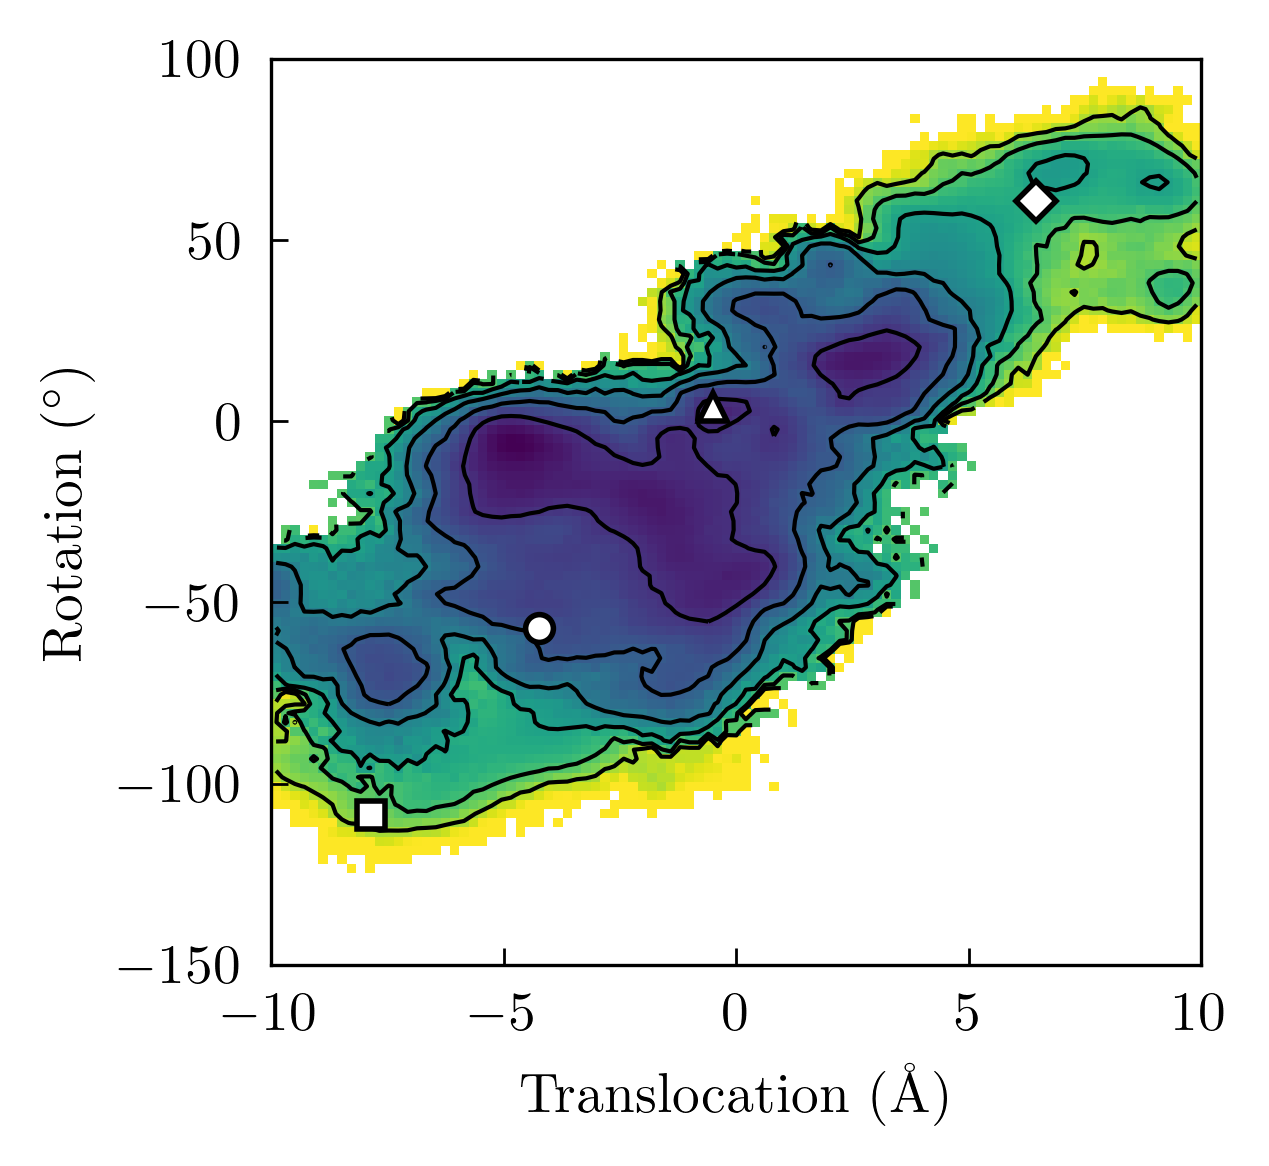

In [83]:
dist_trajs = [traj[:, 0] for traj in cv_trajs]
rot_trajs = [traj[:, 1] for traj in cv_trajs]
xlim = np.linspace(-10, 10, 100)
ylim = np.linspace(-150, 100, 100)

# f, axs = plot_weights(weights_mem, lags, mems, dist_trajs, rot_trajs, xlim, ylim)
weight_test = compute_weights(basisL, [16], [3])
f = plt.figure(figsize=(3, 3), dpi=200)
ax = plt.gca()
xc = (xlim[1:] + xlim[:-1]) / 2
yc = (ylim[1:] + ylim[:-1]) / 2
hist = extq.projection.density2d(dist_trajs, rot_trajs, weight_test[0, 0], xlim, ylim)
offset = np.min(-np.log(hist[np.nonzero(hist)]))
diff = (-np.log(hist) - offset) * 0.593  # convert to kcal/mol
h = ax.pcolormesh(xc, yc, diff.T, cmap='viridis', rasterized=True, vmin=0, vmax=7)
ax.contour(xc, yc, diff.T, colors="black", levels=np.arange(0, 7))
plotting.format_cvs(ax, ms=5)